# Regen Cooling Analysis
The code uses the temperature profile from film cooling to calculate the cooling channels and their factors of safety.

## Importing Libraries

In [1]:
import math
import matplotlib.pyplot as plt
from dask.array import indices
from scipy.optimize import fsolve
from math import exp
from unit_conversions import *
from util import *
import numpy as np
from scipy.integrate import quad

## Engine Parameter Inputs

### Engine Inputs

In [2]:
# Value                    | Units       | Description
#--------------------------+-------------+------------------
gamma = 1.1612             # N/A         | Specific heat ratio
R = 363.6                  # J/kg-K      | Gas constant (From RPA)
visc_g = 1.073e-4         # Pa-s        | Gas viscosity
Cp_g = gamma*R/(gamma-1)   # J/kg-K      | Gas specific heat
Tc_ns = 3319.7994          # K           | Combustion temperature (From CEA)
Pr_g = 0.5416              # N/A         | Gas Prandtl's number (From RPA, NASA equation didn't match well)
pc_ns = bar2Pa(42)       # N/m^2       | Nozzle stagnation pressure
F = kg2N(69)               # N           | Engine thrust
pe = psia2Pa(p_atm)        # N/m^2       | Nozzle exist pressure, atmospheric presure
of_ratio = 1.6             # N/A         | Weight ratio of oxidizer to fuel
contraction_ratio = 20   # N/A         | Ratio of combustion chamber area to throaat area
Lc = 1.66                  # m           | Characteristic length, aka time for combustion
theta_conv = 40            # deg         | Nozzle converging half cone angle
theta_inj = 45             # deg         | Injector converging half cone angle
r_inj_ratio = .6           # N/A         | Fraction of injector face radius to chamber radius
r_3ratio = 0.65

### Heat Transfer Inputs

In [3]:
# Value                      | Units       | Description
#----------------------------+-------------+------------------
k_316 = 15                   # W/m-K       | 316L wall thermal conductivity
E_316 = 1.8e11               # Pa          | Modulus of elasticity for 316L
poisson_316 = 0.29           # N/A         | Poisson's ratio for 316L
cte_316 = 16e-6              # m/m-K         | Coeffecient of thermal expansion for 316L
k_co = 0.167                 # W/m-k       | Ethanol coolant thermal conductivity
shell_thick_i = mm2m(1)      # m           | Thickness of inner chamber wall
shell_thick_o = mm2m(1)      # m           | Outer chamber wall thickness
channel_w = mm2m(1)          # m           | Thickness of channel divider
channel_h = mm2m(1)          # m           | Channel hieght
n_channels = 20              # Int         | Number of cooling channels
theta_chan = 2*pi/n_channels # rad         | Angle a channel takes up
Tco = 293.15                 # K           | Coolant inlet temperature

# Viscosity of ethanol
# Source: https://en.wikipedia.org/wiki/Temperature_dependence_of_viscosity
visc_ethanol = lambda T: (0.00201 * exp(1614/T + 0.00618*T - 1.132E-5*T**2))/1000   # Pa-s
# Isobaric heat capacity of liquid ethanol
# Source (linear fit of straight portion):
Cp_ethanol = lambda T: (0.0109*T-0.6907)*1000   # J/kg-K
# Density of ethanol
# Source: https://www.engineeringtoolbox.com/ethanol-ethyl-alcohol-density-specific-weight-temperature-pressure-d_2028.html
rho_table_T = np.array([250, 280, 310,340,370,400,423.9,430,460,490,501.4,513.9,])  # K
rho_table_rho = np.array([825.2,800.5,775.3,747.8,716.7,680.6,647.2,637.7,584,507.1,461.3,276]) # kg/m^3
rho_ethanol = lambda T: interp(T,rho_table_T, rho_table_rho)

## Engine Definition

### Engine Sizing

In [4]:
# ENGINE SIZING
#-----------------------------------------------------------------------------------------------------------------------
# Calculate exit velocity (m/s) from combustion temperature and pressure
v_e = sqrt((2 * gamma) / (gamma - 1) * R * Tc_ns * (1 - (pe / pc_ns) ** ((gamma - 1) / gamma)))
print(v_e)
Isp = v_e / g # s
print(Isp)
# Calculate total mass flow rate
m_dot = F / v_e # kg/s
m_dot_ox = m_dot*of_ratio/(1+of_ratio) # kg/s
m_dot_fuel = m_dot*1/(1+of_ratio) # kg/s
print(f"m_dot_total {m_dot}")
print(f"m_dot_fuel {m_dot_fuel}")
print(f"m_dot_lox {m_dot_ox}")

# Calculate throat and exit areas    m^2
A_t = m_dot * sqrt(Tc_ns) / (
        pc_ns * sqrt(gamma / R) * ((gamma + 1) / 2) ** (
        -(gamma + 1) / (2 * (gamma - 1))
    )
)
A_e = A_t * (2 / (gamma + 1)) ** (1 / (gamma - 1)) * (pc_ns / pe) ** (1 / gamma) / sqrt(
    (gamma + 1) / (gamma - 1) * (1 - (pe / pc_ns) ** ((gamma - 1) / gamma))
)


2649.6048760110248
270.18450500538154
m_dot_total 0.2553810404435504
m_dot_fuel 0.09822347709367324
m_dot_lox 0.15715756334987718


### Engine Geometry

Expansion Ratio: 6.57
0.014760881060742704
-0.10587498013242097 -0.0955708103057945 -0.04516064835678483 -0.013053076005409538 -0.005553883613424833 0.0009072454044296703
0.07235566945224706 0.0019847727160628155 0.002064839037602097


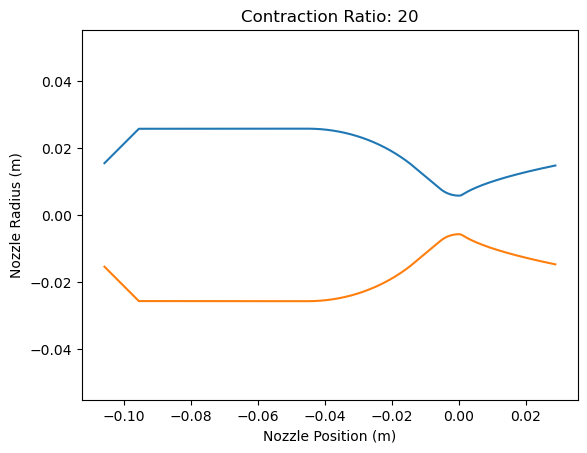

0.1346789228977036


In [5]:
# Parabolic nozzle:
exp_ratio = A_e / A_t
print(f"Expansion Ratio: {exp_ratio:.2f}")
# Parabola starting and exit angles
theta_e = 11.65
theta_n = 24.35
R_t = area2r(A_t)
D_t = 2*R_t
R_e = area2r(A_e)
R_c = area2r(A_t * contraction_ratio)
print(R_e)

R_6 = lambda x: -np.sqrt((0.382 * R_t) ** 2 - x ** 2) + 1.382 * R_t
x_6 = 0.382 * R_t * sind(theta_n)
x_5 = 0
R_5 = lambda x: -np.sqrt((1.5 * R_t) ** 2 - x ** 2) + 2.5 * R_t
x_4 = 1.5 * R_t * sind(-theta_conv)
r_3max = (R_c-R_5(x_4))/(1-cosd(theta_conv))
r_3 = r_3max*r_3ratio
R_4 = lambda x: -tand(theta_conv) * (x - x_4) + R_5(x_4)
x_3 = x_4 - (R_c - R_5(x_4) - r_3*(1 - cosd(theta_conv))) / tand(theta_conv)
x_2 = x_3 - r_3 * sind(theta_conv)
R_3 = lambda x: np.sqrt(r_3 ** 2 - (x - x_2) ** 2) + (R_c-r_3)

def R_conv(z):
    return np.piecewise(
        z,
        [z < x_3, (z >= x_3) & (z < x_4), z >= x_4],
        [R_3, R_4, R_5]
    )

A_conv = lambda x: pi * R_conv(x)**2
Vol_conv = quad(A_conv,x_2,x_5)[0]
r_inj = r_inj_ratio*R_c
h_inj_cone = (R_c - r_inj)/tand(theta_inj)
Vol_inj_cone = 1/3*pi*h_inj_cone*(R_c**2 + r_inj**2 + R_c*r_inj)
Vol_cyl = Lc*A_t - Vol_conv - Vol_inj_cone


L_cyl = Vol_cyl/r2area(R_c)
x_1 = x_2-L_cyl
x_0 = x_1 - h_inj_cone
R_1 = lambda x: tand(theta_inj)*(x-x_1)+R_c

M1 = tand(theta_n)
M2 = tand(theta_e)
x1 = x_6
y1 = R_6(x1)
y2 = area2r(A_e)

c_func = lambda c: np.sqrt(2*M2*(y2-c))*np.sqrt(M2/(2*M1)*(y2-c))+c-y1
c = fsolve(c_func,0)[0]
b = M2/(2*M1)*(y2-c)-x1
a = sqrt(2*M2*(y2-c))
x_7 =((y2-c)/a)**2-b
R_7 = lambda x: a*np.sqrt(x+b)+c

def R_engine(z):
    return np.piecewise(
        z,
        [z < x_1, (z >= x_1)& (z < x_2), (z >= x_2) & (z < x_3), (z >= x_3) & (z < x_4),(z >= x_4) & (z < x_5), (z>=x_5) & (z<= x_6), z>x_6],
        [R_1, R_c, R_3, R_4, R_5, R_6, R_7]
    )
print(f"{x_0} {x_1} {x_2} {x_3} {x_4} {x_6}")
print(f"{a} {b} {c}")

x_list = np.linspace(x_7, x_0, 10000)
plt.plot(x_list, R_engine(x_list))
plt.plot(x_list, -R_engine(x_list))
plt.axis('equal')
plt.xlabel("Nozzle Position (m)")
plt.ylabel("Nozzle Radius (m)")
plt.title(f"Contraction Ratio: {contraction_ratio}")
plt.show()
print(x_7-x_0)

## Thermodynamic Properties

0.25538013344426247
1.0019598645559409


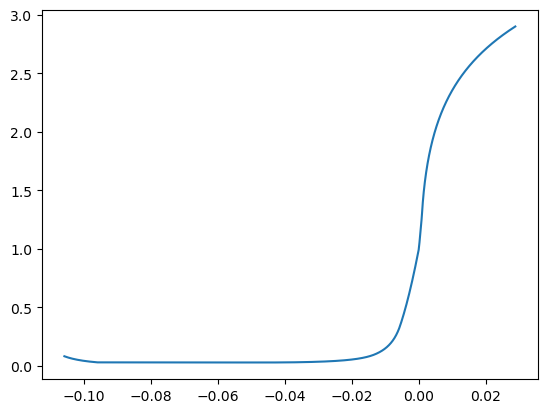

In [ ]:
# THERMODYNAMIC PROPERTIES
#-----------------------------------------------------------------------------------------------------------------------
A_list = r2area(R_engine(x_list))
area_mach_eq = lambda M,A: A/A_t - ((gamma+1)/2)**-((gamma+1)/(2*(gamma-1)))*(1+(gamma-1)/2*M**2)**((gamma+1)/(2*(gamma-1)))/M
#area_mach_eq = lambda M,A: A / A_t - pow(2 / (gamma + 1) * (1 + (gamma - 1) / 2 * M ** 2),
#                                                            (gamma + 1) / (2 * (gamma - 1))) /  M
M_list = np.array([
    fsolve(
        area_mach_eq,
        0.1 if x < x_5 else 2,
        args=(A)
    )[0]
    for A, x in zip(A_list, x_list)
])

# Find gas properties using isentropic relations
recovery_factor = Pr_g**0.33
T_list = Tc_ns*pow(1+(gamma-1)/2*M_list**2,-1)
Taw_list = Tc_ns*(1+recovery_factor*(gamma-1)/2*M_list**2)/(1+(gamma-1)/2*M_list**2)

T_comp = Taw_list/T_list
p_list = pc_ns*pow(1+(gamma-1)/2*M_list**2,-gamma/(gamma-1))
rho_c = pc_ns/(R*Tc_ns)
rho_list = rho_c*pow(1+(gamma-1)/2*M_list**2,-1/(gamma-1))
Vel_list = np.sqrt(gamma*R*T_list)*M_list

## Acoustic Analysis

In [ ]:
# CHAMBER ACOUSTIC MODES
#-----------------------------------------------------------------------------------------------------------------------
L_c = x_4 - x_0             # Length of combustion chamber
A_c = sqrt(gamma*R*Tc_ns)   # Speed of sound m/s
N_L = A_c/(2*L_c)           # Longitudinal frequency, Hz
N_T = 0.59*A_c/(2*R_c)      # Transverse frequency, Hz
N_R = 1.22*A_c/(2*R_c)      # Radial frequency

# Display results
print(f"Longitudinal frequency: {N_L} Hz")
print(f"Longitudinal frequency: {N_T} Hz")
print(f"Longitudinal frequency: {N_R} Hz")

Longitudinal frequency: 5900.639821398774 Hz
Longitudinal frequency: 13557.835848352208 Hz
Longitudinal frequency: 28034.84700845711 Hz


## Heat Transfer

In [ ]:

# REGEN COOLING HEAT TRANSFER
#-----------------------------------------------------------------------------------------------------------------------

hg = None

def friction_factor(D_h, Re_b, Re_w, T_wc, T_co) -> float:
    if Re_b < 3000:
        return 64/Re_b
    epsiolon = microm2m(39.8) #source: Rz of 316L https://xometry.pro/en-eu/articles/3d-printing-surface-roughness/
    colebrook = lambda fr: 1/np.sqrt(fr)+2.0*np.log10(
        epsiolon/(3.72*D_h)+2.51/(Re_b*np.sqrt(fr))
    )
    fdr = fsolve(colebrook,np.array([.04]))[0]
    return fdr*pow(T_wc/T_co,-0.6-5.6*pow(Re_w,-0.38))

# How much do fins chnge heat transfer compared to a flat plate?
def fin_factor(x, h_c) -> float:
    R_wc = R_engine(x)+shell_thick_i
    R_wc2 = R_wc + channel_h
    s = (R_wc*theta_chan - channel_w)/2
    L2 = (R_wc2*theta_chan - channel_w)/2

    m1 = sqrt(2 * h_c / (k_316 * channel_w))
    m2 = sqrt(2 * h_c / (k_316 * shell_thick_o*2))
    c_1 = (
                  exp(2 * channel_h * m1) * (b * m2 * exp(2 * L2 * m2) - b * m2 + m1 * channel_w* exp(2 * L2 * m2) + m1 * channel_w)
          ) / (
                  -b * m2 * exp(2 * channel_h * m1) - b * m2 * exp(2 * L2 * m2) + b * m2 * exp(2 * channel_h * m1 + 2 * L2 * m2)
                  + b * m2 + m1 * channel_w* exp(2 * channel_h * m1) + m1 * channel_w* exp(2 * L2 * m2)
                  + m1 * channel_w* exp(2 * channel_h * m1 + 2 * L2 * m2) + m1 * channel_w
          )
    c_2 = (
              (-b * m2 * exp(2 * L2 * m2) + b * m2 + m1 * channel_w* exp(2 * L2 * m2) + m1 * channel_w)
          ) / (
                  -b * m2 * exp(2 * channel_h * m1) - b * m2 * exp(2 * L2 * m2) + b * m2 * exp(2 * channel_h * m1 + 2 * L2 * m2)
                  + b * m2 + m1 * channel_w* exp(2 * channel_h * m1) + m1 * channel_w* exp(2 * L2 * m2)
                  + m1 * channel_w* exp(2 * channel_h * m1 + 2 * L2 * m2) + m1 *channel_w
          )
    eta_f = 2 * s / (2 * s +channel_w) + k_316 * channel_w* (c_1 * m1 - c_2 * m2) / (h_c * (2 * s +channel_w))
    return eta_f

def heat_trans_eqs(variables, x, Tco, i):
    q, Twg, Twc = variables
    Taw = interp(x, x_list,Taw_list)
    A = interp(x, x_list, A_list)
    M = interp(x, x_list, M_list)

    # COOLANT CONVECTION COEFFECIENT
    #-------------------------------------------------------------------------------------------------------------------
    # Find the hydraulic diameter of the cooling channel
    area_channel = theta_chan/2*((R_engine(x)+shell_thick_i+channel_h)**2 - (R_engine(x)+shell_thick_i)**2) -channel_h* channel_w    # m^2
    perim_channel = 2*channel_h + theta_chan*(R_engine(x)+shell_thick_i+channel_h) + theta_chan*(R_engine(x)+shell_thick_i) - 2* channel_w # m
    d_hyd = 4 * area_channel/perim_channel              # m     Hydraulic diameter

    # Determine physical properties of coolant
    visc_co = visc_ethanol(Tco)                         # Pa-s   Coolant bulk Viscosity
    Cp_co = Cp_ethanol(Tco)                             # J/kg-K Coolant Isobaric heat capacity
    Pr_co = Cp_co * visc_co / k_co                      # N/A    Coolant Prandtl's number
    V_co = 2* m_dot_fuel/n_channels/rho_ethanol(Tco)/area_channel    # m/s    Coolant channel velocity
    Re_co = rho_ethanol(Tco)*V_co*d_hyd/visc_co                   # N/A    Coolant Reynold's number
    Re_w = rho_ethanol(Twc) * V_co * d_hyd / visc_ethanol(Twc)

    if Re_co < 3000:
        hc = k_co/d_hyd*4.36
    elif Re_co < 10000:
        f = friction_factor(d_hyd,Re_co,Re_w,Twc,Tco)
        hc = k_co/d_hyd*((f/8)*(Re_co-1000)*Pr_co)/(1+12.7*(f/8)**.5*(Pr_co**(2/3)-1))
    # Sieder–Tate equation to find coolant heat transfer
    else:
        hc = k_co/d_hyd * 0.027 * Re_co ** 0.8 * Pr_co ** 0.4 * (visc_co/visc_ethanol(Twc)) ** 0.14  # W/m^2-k

    # GAS SIDE CONVECTION COEFFECIENT
    # -------------------------------------------------------------------------------------------------------------------
    sigma = 1/((1/2*Twg/Tc_ns*(1+(gamma-1)/2*M**2)+1/2)**0.68*
               (1+(gamma-1)/2*M**2)**0.12
               )
    hg = h2SI((0.026/(m2in(D_t)**0.2)*
          (visc2Imp(visc_g)**0.2*Cp2Imp(Cp_g)/(Pr_g**0.6))*
               (kg2lb(m_dot)/m22in2(A_t))**0.8*
          (D_t/(0.941*R_t))**0.1    # Use average throat curviture
          )*(A_t/A)**0.9 * sigma)
    hg_list[i] = hg
    # Heat transfer equations
    eq1 = q - hg*(Taw - Twg)
    eq2 = q - k_316*(Twg-Twc)/shell_thick_i
    eq3 = q - fin_factor(x,hc)*hc*(Twc - Tco)
    return [eq1, eq2, eq3]

# Initial conditions
initial_guess = np.array([3.5e6,1100,700])
dx = abs(x_list[2]-x_list[1])

# Array initializtion
dA_list = np.zeros(x_list.shape)
q_list = np.zeros(x_list.shape)
Twg_list = np.zeros(x_list.shape)
Twc_list = np.zeros(x_list.shape)
Tco_list = np.zeros(x_list.shape)
Dco_hyd_list = np.zeros(x_list.shape)
Vco_list = np.zeros(x_list.shape)
deltaP_list = np.zeros(x_list.shape)
stress_list = np.zeros(x_list.shape)
hg_list = np.zeros(x_list.shape)

#solution = fsolve(heat_trans_eqs,initial_guess, args=(x_list[0],Tco,))
#print(f"q: {solution[0]}\tTwg: {solution[1]}\tTwc: {solution[2]}")

# Loop through each point starting from the nozzle and workin back to injector
for i, x in enumerate(x_list):
    # Calculate change in area
    epsilon = 0.000001
    dRdx = (R_engine(x + epsilon) - R_engine(x)) / epsilon
    L = dx * sqrt(1 + dRdx ** 2)
    dA = 2 * pi * (R_engine(x) + shell_thick_i) * L
    dA_list[i] = dA

    # Solve heat transfer steady state, store results
    solution = fsolve(heat_trans_eqs,initial_guess, args=(x,Tco,i,))
    Tco_list[i] = Tco
    q_list[i] = solution[0]
    Twg_list[i] = solution[1]
    Twc_list[i] = solution[2]

    # Update values for next loop
    initial_guess = np.array([q_list[i], Twg_list[i], Twc_list[i]])
    Tco += q_list[i] * dA / (m_dot_fuel * Cp_ethanol(Tco))

    # PRESSURE DROPS
    #------------------------------------
    # Find the hydraulic diameter of the cooling channel
    area_channel = theta_chan / 2 * (
                (R_engine(x) + shell_thick_i + channel_h) ** 2 - (R_engine(x) + shell_thick_i) ** 2) - channel_h * channel_w  # m^2
    perim_channel = 2 * channel_h + theta_chan * (R_engine(x) + shell_thick_i + channel_h) + theta_chan * (
                R_engine(x) + shell_thick_i) - 2 * channel_w  # m
    d_hyd = 4 * area_channel / perim_channel  # m     Hydraulic diameter

    # Determine physical properties of coolant
    visc_co = visc_ethanol(Tco)  # Pa-s   Coolant bulk Viscosity
    Cp_co = Cp_ethanol(Tco)  # J/kg-K Coolant Isobaric heat capacity
    Pr_co = Cp_co * visc_co / k_co  # N/A    Coolant Prandtl's number
    V_co = 2*m_dot_fuel / n_channels / rho_ethanol(Tco)/ area_channel  # m/s    Coolant channel velocity #rho_ethanol(Tco)
    Re_co = rho_ethanol(Tco) * V_co * d_hyd / visc_co  # N/A    Coolant Reynold's number
    Re_w = rho_ethanol(Twc_list[i]) * V_co * d_hyd / visc_ethanol(Twc_list[i])

    Dco_hyd_list[i] = d_hyd
    deltaP_list[i] = friction_factor(d_hyd,Re_co,Re_w,Twc_list[i],Tco) * (L/d_hyd) * rho_ethanol(Tco)/2 * V_co**2
    stress_list[i] = (pc_ns*1.1-p_list[i])*R_engine(x)/shell_thick_i + E_316*cte_316*q_list[i]*shell_thick_i/(2*(1-poisson_316)*k_316)
    Vco_list[i] = V_co
    print(hg_list[i])
    #print(Twg_list[i]-Twc_list[i])
    #print(Pa2MPa(stress_list[i]))
    #print

#print(np.sum(deltaP_list))
print(Pa2psia(np.sum(deltaP_list)))
#print(np.sum(dA_list))
T_boil = 200+273
T_i = 293
T_avg = (T_boil+T_i)/2
H_vap = 900000
eta = 0.5

indices = (x_list>=x_3)
A_cool = np.sum(dA_list[indices])
m_film = A_cool/eta/(Cp_ethanol(T_avg)*(T_boil-T_i)/(7000*(Tc_ns-T_avg)) + H_vap/(7000*(Tc_ns-T_boil)))
print(f"Film cooling mass flow: {m_film}")
print(f"Fuel mass flow {m_dot_fuel}")

plt.plot(x_list, Pa2MPa(stress_list))
plt.ylabel("Stress (MPa)")
plt.show()

mass_frac = lambda m_film: (Tc_ns-(800+273))/(Tc_ns-450) - np.exp(-1400/(m_film/.012*7500*.25))
print("Coolant flow rate:")
print(fsolve(mass_frac,0.07)[0])
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot q_list vs x_list on the left axis
ax1.plot(x_list[:-1], q_list[:-1]/2943623, color='blue', label='Heat Flux')
ax1.set_xlabel('Nozzle Position (m)')
ax1.set_ylabel('Heat Flux (W/m^2)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for Twc_list
ax2 = ax1.twinx()
ax2.plot(x_list[:-1], Twc_list[:-1], color='red', label='Coolant Side Wall Temp')
ax2.set_ylabel('Coolant Side Wall Temp (K)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(Taw_list)*1.05)

# Create a third y-axis for Twg_list
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 50))  # Offset the third axis to the right
ax3.plot(x_list[:-1], Twg_list[:-1], color='green', label='Gas Side Wall Temp')
ax3.set_ylabel('Gas Side Wall Temp (K)', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_ylim(0, max(Taw_list)*1.05)

# Create a fourth y-axis for Tco_list
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 100))  # Further offset the fourth axis
ax4.plot(x_list[:-1], Tco_list[:-1], color='orange', label='Coolant Temp')
ax4.set_ylabel('Coolant Temp (K)', color='orange')
ax4.tick_params(axis='y', labelcolor='orange')

# Create a fourth y-axis for Tco_list
ax5 = ax1.twinx()
ax5.spines['right'].set_position(('outward', 150))  # Further offset the fourth axis
ax5.plot(x_list[:-1], Taw_list[:-1], color='purple', label='Adiabatic Wall')
ax5.set_ylabel('Adiabatic Temp (K)', color='purple')
ax5.tick_params(axis='y', labelcolor='purple')
ax5.set_ylim(0, max(Taw_list)*1.05)

# Show the plot
fig.tight_layout()  # To ensure everything fits
plt.title("Without Fin Factor")
plt.show()

4111.483463583834
4112.991574352082
4114.500688344943
4116.010806728736
4117.521930671857
4119.034061344525
4120.54719991878
4122.061347568479
4123.576505469311
4125.09267479879
4126.609856736265
4128.128052462929
4129.647263161807
4131.167490017775
4132.688734217547
4134.210996949704
4135.7342794046735
4137.258582774737
4138.78390825405
4140.310257038626
4141.837630326354
4143.3660293169905
4144.895455212173
4146.425909215423
4147.957392532143
4149.489906369621
4151.023451937045
4152.558030445492
4154.093643107941
4155.630291139276
4157.167975756287
4158.706698177675
4160.246459624054
4161.787261317961
4163.32910448385
4164.871990348104
4166.415920139035
4167.960895086891
4169.506916423854
4171.053985384047
4172.602103203548
4174.151271120371
4175.701490374488
4177.252762207831
4178.80508786429
4180.3584685897185
4181.912905631946
4183.468400240761
4185.024953667943
4186.58256716724
4188.141241994393
4189.700979407127
4191.261780665159
4192.823647030206
4194.386579765984
4195.95058013